# Installation

```bash
conda create --name lec5 python=3.9
conda activate lec5
pip install --quiet "setuptools==59.5.0" "pytorch-lightning>=1.4" "matplotlib" "torch>=1.8" "ipython[notebook]" "torchmetrics>=0.7" "torchvision" "seaborn"
```

# Code Walkthrough

In [13]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
import pytorch_lightning as pl
import os

DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(
            (32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
            [0.24703223, 0.24348513, 0.26158784]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
        [0.24703223, 0.24348513, 0.26158784]),
    ]
)

train_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=train_transform,download=True)
val_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=test_transform, download=True)
test_set = CIFAR10(
    root=DATASET_PATH, train=False, transform=test_transform,download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Files already downloaded and verified


In [14]:
import torch
import torch.utils.data as data

pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])


Global seed set to 42
Global seed set to 42


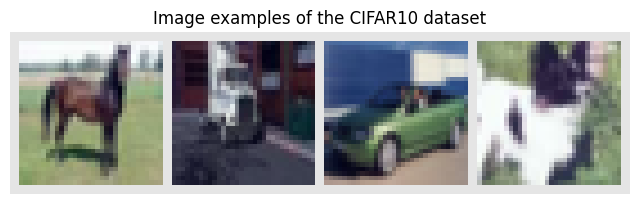

In [15]:
import matplotlib.pyplot as plt
import torchvision

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack(
    [val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(
    CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


In [16]:
train_loader = data.DataLoader(
    train_set, batch_size=16,
    shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = data.DataLoader(
    val_set, batch_size=16,
    shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(
    test_set, batch_size=16,
    shuffle=False, drop_last=False, num_workers=2)

In [17]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the
            patches (integer)
        flatten_channels - If True, the patches will be
            returned in a flattened format as a feature
            vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(
        B,
        C,
        torch.div(H, patch_size, rounding_mode='trunc'),
        patch_size,
        torch.div(W, patch_size, rounding_mode='floor'),
        patch_size,
    )
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

img_patches = img_to_patch(
    CIFAR_images, patch_size=4, flatten_channels=False)

img_patches.shape

torch.Size([4, 64, 3, 4, 4])

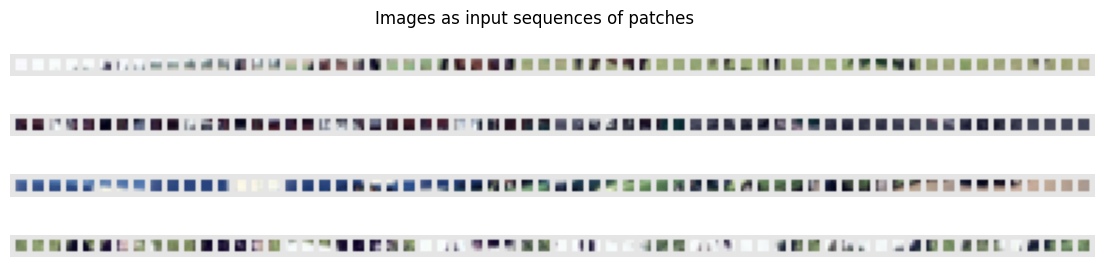

In [18]:
fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14, 3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(
        img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [19]:
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [20]:
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [21]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        super().__init__()
        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(
            num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(
                embed_dim, hidden_dim, num_heads, dropout=dropout)
                    for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(
            torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [22]:
import torch.nn.functional as F
import torch.optim as optim

class ViT(pl.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [23]:
from pytorch_lightning.callbacks import ModelCheckpoint

CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")

def train_model(**kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        limit_train_batches=10,
        limit_val_batches=10,
        limit_test_batches=10,
        log_every_n_steps=10,
        max_steps=20,
    )

    pl.seed_everything(42)  # To be reproducible
    model = ViT(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    
    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [24]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 256,
        "hidden_dim": 512,
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": 4,
        "num_channels": 3,
        "num_patches": 64,
        "num_classes": 10,
        "dropout": 0.2,
    },
    lr=3e-4,
)
print("ViT results", results)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
Missing logger folder: saved_models/VisionTransformers/ViT/lightning_logs

  | Name  | Type              | Params | In sizes        | Out sizes
--------------------------------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | [16, 3, 32, 32] | [16, 10] 
--------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.781    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]